# Gap Filling Data Preperation

Preparing the data for the gap-filling models: loading CHL data and splitting data into training, testing and validation datasets

In [1]:
import xarray as xr
import numpy as np
import os
from skimage import io as skio
!python -m pip install netCDF4
import netCDF4 as nc
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.animation as animation
import datetime as dt
import pandas as pd
from sklearn.model_selection import train_test_split
from netCDF4 import Dataset, num2date
import h5py

input_dir_RIGA = r'/content/drive/MyDrive/MasterThesis/Data/CHL_1km/values_Riga'
input_dir_KTT = r'/content/drive/MyDrive/MasterThesis/Data/CHL_1km/values_Kattegat'
input_dir_GTL = r'/content/drive/MyDrive/MasterThesis/Data/CHL_1km/values_Gotland'

output_dir = r'/content/drive/MyDrive/MasterThesis/DINpCAE'



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set a random seed to ensure that all basins have the same test data
np.random.seed(42)

## First load and prepare the Multi data

In [ ]:
def prepare_multi_data(input_dir, output_dir, area):
  # load the multi data from file
  chl_array_multi = np.empty((0,160,160))
  for i in range(9):
    file = f'CHL_data_multi_{i}.npy'
    print(file)
    txt = np.load(f'{input_dir}/{file}')
    chl_array_multi= np.append(chl_array_multi, txt, axis=0)

  print(f"Multi Array Shape: {chl_array_multi.shape}")


  # read the mask
  mask_file = r'/mask.npy'
  mask_data = np.load(f'{input_dir}/{mask_file}')
  landmask = np.where(mask_data == 0, 1, 0)

  # mask the data
  mask_chl = np.where(landmask==1,chl_array_multi, np.nan)
  fix, ax = plt.subplots(1,2)
  ax[0].imshow(mask_chl[303,:,:])
  ax[1].imshow(chl_array_multi[303,:,:])
  plt.show()

  # get the max number of pixels that are not non in dimension 1 and 2
  max_pixels = max(np.sum(~np.isnan(mask_chl), axis=(1,2)))
  print(f"Max Pixels: {max_pixels}")

  # split chl array into 20 day blocks
  splitting_array = np.arange(20, chl_array_multi.shape[0], 20)
  chl_np_array = np.split(mask_chl, splitting_array, axis=0)[:-1]
  print(f"Number of 20 day blocks: {len(chl_np_array)}")
  print(f"Shape of single chl block: {chl_np_array[0].shape}")

  # load longitude and latitude from file
  longitudes = np.loadtxt(f'{input_dir}/longitudes.txt')
  latitudes = np.loadtxt(f'{input_dir}/latitudes.txt')
  time_array = pd.date_range(start='1997-09-04', end='2021-12-31', freq='D')
  print(f"Time array: {time_array}")

  # # kepp only the date without time
  # time_array = time_array.astype('datetime64[s]')
  # time_array = time_array.astype(dt.datetime)

  splitting_array = np.arange(20, time_array.shape[0], 20)
  time_split = np.split(time_array, splitting_array, axis=0)[:-1]
  print(f"Numer of 20 day times: {len(time_split)}")
  print(f"Length of total Time array: {len(time_array)}")

  # Define the training and test and validation samples

  # In the first step we will split the data in training and remaining dataset
  X_train_ind, X_rem_ind, y_train, y_rem = train_test_split(np.arange(len(chl_np_array)),np.arange(len(chl_np_array)), train_size=0.8)

  # Now since we want the valid and test size to be equal (10% each of overall data).
  # we have to define valid_size=0.5 (that is 50% of remaining data)
  X_valid_ind, X_test_ind, y_valid, y_test = train_test_split(X_rem_ind,y_rem, test_size=0.5)

  print(f"Train data indices: {X_train_ind}")
  print(f"Validation data indices: {X_valid_ind}")
  print(f"Test data indices: {X_test_ind}")

  # Setup a netcfd file for every time block of 20 days
  nr_valid_files_train_10 = 0
  nr_valid_files_test_10 = 0
  nr_valid_files_val_10 = 0
  nr_valid_files_train_20 = 0
  nr_valid_files_test_20 = 0
  nr_valid_files_val_20 = 0
  nr_valid_files_train_30 = 0
  nr_valid_files_test_30 = 0
  nr_valid_files_val_30 = 0
  nr_valid_files_train_40 = 0
  nr_valid_files_test_40 = 0
  nr_valid_files_val_40 = 0
  nr_valid_files_train_50 = 0
  nr_valid_files_test_50 = 0
  nr_valid_files_val_50 = 0
  for t in range(len(chl_np_array)):
      if np.sum(~np.isnan(chl_np_array[t])) >= 0.2*20*max_pixels and np.sum(~np.isnan(chl_np_array[t])) <= 0.3*20*max_pixels:
        name = f'file_multi_20-30_{t}.nc'
      elif np.sum(~np.isnan(chl_np_array[t])) >= 0.0*20*max_pixels and np.sum(~np.isnan(chl_np_array[t])) <= 0.1*20*max_pixels:
        name = f'file_multi_00-10_{t}.nc'
      elif np.sum(~np.isnan(chl_np_array[t])) >= 0.1*20*max_pixels and np.sum(~np.isnan(chl_np_array[t])) <= 0.2*20*max_pixels:
        name = f'file_multi_10-20_{t}.nc'
      elif np.sum(~np.isnan(chl_np_array[t])) >= 0.3*20*max_pixels and np.sum(~np.isnan(chl_np_array[t])) <= 0.4*20*max_pixels:
        name = f'file_multi_30-40_{t}.nc'
      elif np.sum(~np.isnan(chl_np_array[t])) >= 0.4*20*max_pixels and np.sum(~np.isnan(chl_np_array[t])) <= 0.5*20*max_pixels:
        name = f'file_multi_40-50_{t}.nc'
      else:
        name = f'file_multi_50-100_{t}.nc'

      print(f"File {t} has Percentage: {np.sum(~np.isnan(chl_np_array[t]))/(20*max_pixels)}")
      time_units = f"days since 1900-01-01 00:00:00"
      # create netcdf
      if t in X_train_ind:
        fn = f'{output_dir}/TrainData_NC_{area}/{name}'
        if '10-20' in name:
          nr_valid_files_train_10 += 1
        elif '20-30' in name:
          nr_valid_files_train_20 += 1
        elif '30-40' in name:
          nr_valid_files_train_30 += 1
        elif '40-50' in name:
          nr_valid_files_train_40 += 1
        elif '50-100' in name:
          nr_valid_files_train_50 += 1
      elif t in X_test_ind:
        fn = f'{output_dir}/TestData_NC_{area}/{name}'
        if '10-20' in name:
          nr_valid_files_test_10 += 1
        elif '20-30' in name:
          nr_valid_files_test_20 += 1
        elif '30-40' in name:
          nr_valid_files_test_30 += 1
        elif '40-50' in name:
          nr_valid_files_test_40 += 1
        elif '50-100' in name:
          nr_valid_files_test_50 += 1
      elif t in X_valid_ind:
        fn = f'{output_dir}/ValData_NC_{area}/{name}'
        if '10-20' in name:
          nr_valid_files_val_10 += 1
        elif '20-30' in name:
          nr_valid_files_val_20 += 1
        elif '30-40' in name:
          nr_valid_files_val_30 += 1
        elif '40-50' in name:
          nr_valid_files_val_40 += 1
        elif '50-100' in name:
          nr_valid_files_val_50 += 1
      ds = nc.Dataset(fn, 'w', format='NETCDF4', engine='h5netcdf')

      time = ds.createDimension('time', None)
      lat = ds.createDimension('lat', chl_np_array[t].shape[1])
      lon = ds.createDimension('lon', chl_np_array[t].shape[2])

      timeseries = ds.createVariable('time', float, ('time',))
      lats = ds.createVariable('lat', float, ('lat',))
      lons = ds.createVariable('lon', float, ('lon',))
      value = ds.createVariable('CHL', float, ('time', 'lat', 'lon',), fill_value=-9999.0)
      timeseries.units = time_units

      mask_value = ds.createVariable('mask', float, ('lat', 'lon',))

      lats[:] = latitudes
      lons[:] = longitudes

      chl_np_array[t][np.isnan(chl_np_array[t])] = -9999.0
      value[:,:,:] = chl_np_array[t]
      mask_value[:,:] = landmask


      mdate = np.array([(t_ - dt.datetime(1900, 1, 1)).total_seconds() / (24 * 60 * 60) for t_ in time_split[t]])
      timeseries[:] = mdate
      ds.close()

  print(f"Number of files with more than 10% data for Training: {nr_valid_files_train_10 + nr_valid_files_train_20 + nr_valid_files_train_30 + nr_valid_files_train_40 + nr_valid_files_train_50}")
  print(f"Number of files with more than 10% data for Testing: {nr_valid_files_test_10 + nr_valid_files_test_20 + nr_valid_files_test_30 + nr_valid_files_test_40 + nr_valid_files_test_50}")
  print(f"Number of files with more than 10% data for Validation: {nr_valid_files_val_10 + nr_valid_files_val_20 + nr_valid_files_val_30 + nr_valid_files_val_40 + nr_valid_files_val_50}")

  print(f"Number of files with more than 20% data for Training: {nr_valid_files_train_20 + nr_valid_files_train_30 + nr_valid_files_train_40 + nr_valid_files_train_50}")
  print(f"Number of files with more than 20% data for Testing: {nr_valid_files_test_20 + nr_valid_files_test_30 + nr_valid_files_test_40 + nr_valid_files_test_50}")
  print(f"Number of files with more than 20% data for Validation: {nr_valid_files_val_20 + nr_valid_files_val_30 + nr_valid_files_val_40 + nr_valid_files_val_50}")

  print(f"Number of files with more than 30% data for Training: {nr_valid_files_train_30 + nr_valid_files_train_40 + nr_valid_files_train_50}")
  print(f"Number of files with more than 30% data for Testing: {nr_valid_files_test_30 + nr_valid_files_test_40 + nr_valid_files_test_50}")
  print(f"Number of files with more than 30% data for Validation: {nr_valid_files_val_30 + nr_valid_files_val_40 + nr_valid_files_val_50}")

  print(f"Number of files with more than 40% data for Training: {nr_valid_files_train_40 + nr_valid_files_train_50}")
  print(f"Number of files with more than 40% data for Testing: {nr_valid_files_test_40 + nr_valid_files_test_50}")
  print(f"Number of files with more than 40% data for Validation: {nr_valid_files_val_40 + nr_valid_files_val_50}")

  print(f"Number of files with more than 50% data for Training: {nr_valid_files_train_50}")
  print(f"Number of files with more than 50% data for Testing: {nr_valid_files_test_50}")
  print(f"Number of files with more than 50% data for Validation: {nr_valid_files_val_50}")



CHL_data_multi_0.npy
CHL_data_multi_1.npy
CHL_data_multi_2.npy
CHL_data_multi_3.npy
CHL_data_multi_4.npy
CHL_data_multi_5.npy
CHL_data_multi_6.npy
CHL_data_multi_7.npy
CHL_data_multi_8.npy
Multi Array Shape: (8885, 160, 160)


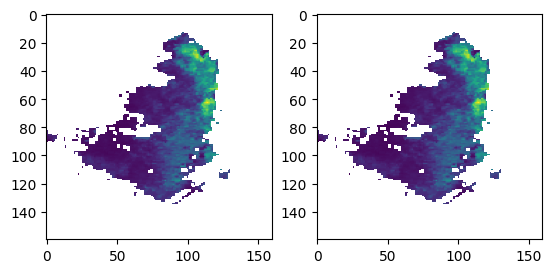

Max Pixels: 12349
Number of 20 day blocks: 444
Shape of single chl block: (20, 160, 160)
Time array: DatetimeIndex(['1997-09-04', '1997-09-05', '1997-09-06', '1997-09-07',
               '1997-09-08', '1997-09-09', '1997-09-10', '1997-09-11',
               '1997-09-12', '1997-09-13',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=8885, freq='D')
Numer of 20 day times: 444
Length of total Time array: 8885
Train data indices: [344 269  97 130   4  74  52  11  96 285 171 388 398 401 204  66  55 164
   6  71 216 229 413   1  22 355 193  94  19 327 378 142 129 407 431 291
 429  63 218  12  79  26 245 120 133 143 203 282  13  32 438 426 260  42
  82 397 145 238 176 200  99 177 158 347 299 233 232  48  62 439 412  51
 280 419 250 386  72 286 181 258 214 175 434 150   0 267 166  95 437 103
 36

In [ ]:
prepare_multi_data(input_dir_RIGA, output_dir, 'RIGA')

CHL_data_multi_0.npy
CHL_data_multi_1.npy
CHL_data_multi_2.npy
CHL_data_multi_3.npy
CHL_data_multi_4.npy
CHL_data_multi_5.npy
CHL_data_multi_6.npy
CHL_data_multi_7.npy
CHL_data_multi_8.npy
Multi Array Shape: (8885, 160, 160)


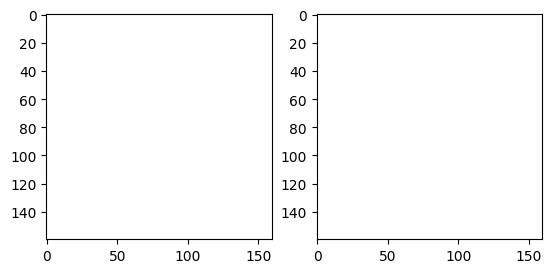

Max Pixels: 16139
Number of 20 day blocks: 444
Shape of single chl block: (20, 160, 160)
Time array: DatetimeIndex(['1997-09-04', '1997-09-05', '1997-09-06', '1997-09-07',
               '1997-09-08', '1997-09-09', '1997-09-10', '1997-09-11',
               '1997-09-12', '1997-09-13',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=8885, freq='D')
Numer of 20 day times: 444
Length of total Time array: 8885
Train data indices: [182 388 122 186 242 381 433 164  80 288 210  44 126 321  52 106 420 340
  12 198 134 413 331  86 265 355 183 295 272  20 390 421 423 245 161 239
 194 139 410 305 176 371  61 291  62 348 256 435 123 328 237  16  39 102
 280   3  96 277 196 221 440 218 185  98 136  82  55 418 125 232  88 325
 271 360 249 362 212  42  92 402 190 432 339 294 347  30 188  91  95 127
  3

In [ ]:
prepare_multi_data(input_dir_KTT, output_dir, 'KTT')

CHL_data_multi_0.npy
CHL_data_multi_1.npy
CHL_data_multi_2.npy
CHL_data_multi_3.npy
CHL_data_multi_4.npy
CHL_data_multi_5.npy
CHL_data_multi_6.npy
CHL_data_multi_7.npy
CHL_data_multi_8.npy
Multi Array Shape: (8885, 160, 160)


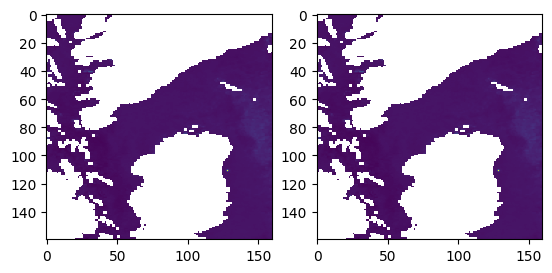

Max Pixels: 25600
Number of 20 day blocks: 444
Shape of single chl block: (20, 160, 160)
Time array: DatetimeIndex(['1997-09-04', '1997-09-05', '1997-09-06', '1997-09-07',
               '1997-09-08', '1997-09-09', '1997-09-10', '1997-09-11',
               '1997-09-12', '1997-09-13',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=8885, freq='D')
Numer of 20 day times: 444
Length of total Time array: 8885
Train data indices: [ 92 234 401  24 342 133 237  94 165 171  33 427 359 280 221 328  15  45
 150 189   8 338 354 278 265  93 382 416 299  47 273 406 306 384   0 170
 377 101  39 385 113  26 379 439 235  79 266 129 149 366 370 442 330 326
 374  71 418  40   7 391 425  10 314 243 122 241  22   5  41  96 275 270
 152 261 346  25 431 317 196 154 402  91 175  78 281 303 345 109  67 231
 25

In [ ]:
prepare_multi_data(input_dir_GTL, output_dir, 'GTL')

## Then Load and prepare the Olci data

In [ ]:
def prepare_olci_data(input_dir, output_dir, area):
  # load the olci data from file
  chl_array_olci = np.empty((0,160,160))
  for i in range(7, 15, 1):
    file = f'CHL_data_{i}.npy'
    print(file)
    txt = np.load(f'{input_dir}/{file}')
    chl_array_olci= np.append(chl_array_olci, txt, axis=0)

  print(chl_array_olci.shape)

  # read the mask
  mask_file = r'/mask.npy'
  mask_data = np.load(f'{input_dir}/{mask_file}')
  landmask = np.where(mask_data == 0, 1, 0)

  # mask the data
  mask_chl = np.where(landmask==1,chl_array_olci, np.nan)
  fix, ax = plt.subplots(1,2)
  ax[0].imshow(mask_chl[103,:,:])
  ax[1].imshow(chl_array_olci[103,:,:])
  plt.show()

  # get the max number of pixels that are not non in dimension 1 and 2
  if area == 'GTL':
    max_pixels = 25600
  elif area == 'KTT':
    max_pixels = 16139
  elif area == 'RIGA':
    max_pixels = 12349
  print(f"Max Pixels: {max_pixels}")

  # split chl array into 20 day blocks
  splitting_array = np.arange(20, chl_array_olci.shape[0], 20)
  chl_np_array = np.split(mask_chl, splitting_array, axis=0)[:-1]
  print(f"Number of 20 day blocks: {len(chl_np_array)}")
  print(f"Shape of single chl block: {chl_np_array[0].shape}")

  # load longitude and latitude from file
  longitudes = np.loadtxt(f'{input_dir}/longitudes.txt')
  latitudes = np.loadtxt(f'{input_dir}/latitudes.txt')
  #time_array = np.loadtxt(f'{input_dir}/timeframe_olci.txt')
  time_array = pd.date_range(start='2016-05-01', end='2023-04-15', freq='D')
  print(f"Time array: {time_array}")

  # # kepp only the date without time
  # time_array = time_array.astype('datetime64[s]')
  # time_array = time_array.astype(dt.datetime)

  splitting_array = np.arange(20, time_array.shape[0], 20)
  time_split = np.split(time_array, splitting_array, axis=0)[:-1]
  print(f"Numer of 20 day times: {len(time_split)}")
  print(f"Length of total Time array: {len(time_array)}")

  # Define the training and test and validation samples

  # In the first step we will split the data in training and remaining dataset
  X_train_ind, X_rem_ind, y_train, y_rem = train_test_split(np.arange(len(chl_np_array)),np.arange(len(chl_np_array)), train_size=0.8)

  # Now since we want the valid and test size to be equal (10% each of overall data).
  # we have to define valid_size=0.5 (that is 50% of remaining data)
  X_valid_ind, X_test_ind, y_valid, y_test = train_test_split(X_rem_ind,y_rem, test_size=0.5)

  print(f"Train data indices: {X_train_ind}")
  print(f"Validation data indices: {X_valid_ind}")
  print(f"Test data indices: {X_test_ind}")

  # Setup a netcfd file for every time block of 20 days
  nr_valid_files_train_10 = 0
  nr_valid_files_test_10 = 0
  nr_valid_files_val_10 = 0
  nr_valid_files_train_20 = 0
  nr_valid_files_test_20 = 0
  nr_valid_files_val_20 = 0
  nr_valid_files_train_30 = 0
  nr_valid_files_test_30 = 0
  nr_valid_files_val_30 = 0
  nr_valid_files_train_40 = 0
  nr_valid_files_test_40 = 0
  nr_valid_files_val_40 = 0
  nr_valid_files_train_50 = 0
  nr_valid_files_test_50 = 0
  nr_valid_files_val_50 = 0
  for t in range(len(chl_np_array)):
      if np.sum(~np.isnan(chl_np_array[t])) >= 0.2*20*max_pixels and np.sum(~np.isnan(chl_np_array[t])) <= 0.3*20*max_pixels:
        name = f'file_olci_20-30_{t}.nc'
      elif np.sum(~np.isnan(chl_np_array[t])) >= 0.0*20*max_pixels and np.sum(~np.isnan(chl_np_array[t])) <= 0.1*20*max_pixels:
        name = f'file_olci_00-10_{t}.nc'
      elif np.sum(~np.isnan(chl_np_array[t])) >= 0.1*20*max_pixels and np.sum(~np.isnan(chl_np_array[t])) <= 0.2*20*max_pixels:
        name = f'file_olci_10-20_{t}.nc'
      elif np.sum(~np.isnan(chl_np_array[t])) >= 0.3*20*max_pixels and np.sum(~np.isnan(chl_np_array[t])) <= 0.4*20*max_pixels:
        name = f'file_olci_30-40_{t}.nc'
      elif np.sum(~np.isnan(chl_np_array[t])) >= 0.4*20*max_pixels and np.sum(~np.isnan(chl_np_array[t])) <= 0.5*20*max_pixels:
        name = f'file_olci_40-50_{t}.nc'
      else:
        name = f'file_olci_50-100_{t}.nc'

      print(f"File {t} has Percentage: {np.sum(~np.isnan(chl_np_array[t]))/(20*max_pixels)}")
      time_units = f"days since 1900-01-01 00:00:00"
      # create netcdf
      if t in X_train_ind:
        fn = f'{output_dir}/TrainData_NC_{area}/{name}'
        if '10-20' in name:
          nr_valid_files_train_10 += 1
        elif '20-30' in name:
          nr_valid_files_train_20 += 1
        elif '30-40' in name:
          nr_valid_files_train_30 += 1
        elif '40-50' in name:
          nr_valid_files_train_40 += 1
        elif '50-100' in name:
          nr_valid_files_train_50 += 1
      elif t in X_test_ind:
        fn = f'{output_dir}/TestData_NC_{area}/{name}'
        if '10-20' in name:
          nr_valid_files_test_10 += 1
        elif '20-30' in name:
          nr_valid_files_test_20 += 1
        elif '30-40' in name:
          nr_valid_files_test_30 += 1
        elif '40-50' in name:
          nr_valid_files_test_40 += 1
        elif '50-100' in name:
          nr_valid_files_test_50 += 1
      elif t in X_valid_ind:
        fn = f'{output_dir}/ValData_NC_{area}/{name}'
        if '10-20' in name:
          nr_valid_files_val_10 += 1
        elif '20-30' in name:
          nr_valid_files_val_20 += 1
        elif '30-40' in name:
          nr_valid_files_val_30 += 1
        elif '40-50' in name:
          nr_valid_files_val_40 += 1
        elif '50-100' in name:
          nr_valid_files_val_50 += 1
      ds = nc.Dataset(fn, 'w', format='NETCDF4', engine='h5netcdf')

      time = ds.createDimension('time', None)
      lat = ds.createDimension('lat', chl_np_array[t].shape[1])
      lon = ds.createDimension('lon', chl_np_array[t].shape[2])

      timeseries = ds.createVariable('time', float, ('time',))
      lats = ds.createVariable('lat', float, ('lat',))
      lons = ds.createVariable('lon', float, ('lon',))
      value = ds.createVariable('CHL', float, ('time', 'lat', 'lon',), fill_value=-9999.0)
      timeseries.units = time_units

      mask_value = ds.createVariable('mask', float, ('lat', 'lon',))

      lats[:] = latitudes
      lons[:] = longitudes

      chl_np_array[t][np.isnan(chl_np_array[t])] = -9999.0
      value[:,:,:] = chl_np_array[t]
      mask_value[:,:] = landmask


      mdate = np.array([(t_ - dt.datetime(1900, 1, 1)).total_seconds() / (24 * 60 * 60) for t_ in time_split[t]])
      timeseries[:] = mdate
      ds.close()

  print(f"Number of files with more than 10% data for Training: {nr_valid_files_train_10 + nr_valid_files_train_20 + nr_valid_files_train_30 + nr_valid_files_train_40 + nr_valid_files_train_50}")
  print(f"Number of files with more than 10% data for Testing: {nr_valid_files_test_10 + nr_valid_files_test_20 + nr_valid_files_test_30 + nr_valid_files_test_40 + nr_valid_files_test_50}")
  print(f"Number of files with more than 10% data for Validation: {nr_valid_files_val_10 + nr_valid_files_val_20 + nr_valid_files_val_30 + nr_valid_files_val_40 + nr_valid_files_val_50}")

  print(f"Number of files with more than 20% data for Training: {nr_valid_files_train_20 + nr_valid_files_train_30 + nr_valid_files_train_40 + nr_valid_files_train_50}")
  print(f"Number of files with more than 20% data for Testing: {nr_valid_files_test_20 + nr_valid_files_test_30 + nr_valid_files_test_40 + nr_valid_files_test_50}")
  print(f"Number of files with more than 20% data for Validation: {nr_valid_files_val_20 + nr_valid_files_val_30 + nr_valid_files_val_40 + nr_valid_files_val_50}")

  print(f"Number of files with more than 30% data for Training: {nr_valid_files_train_30 + nr_valid_files_train_40 + nr_valid_files_train_50}")
  print(f"Number of files with more than 30% data for Testing: {nr_valid_files_test_30 + nr_valid_files_test_40 + nr_valid_files_test_50}")
  print(f"Number of files with more than 30% data for Validation: {nr_valid_files_val_30 + nr_valid_files_val_40 + nr_valid_files_val_50}")

  print(f"Number of files with more than 40% data for Training: {nr_valid_files_train_40 + nr_valid_files_train_50}")
  print(f"Number of files with more than 40% data for Testing: {nr_valid_files_test_40 + nr_valid_files_test_50}")
  print(f"Number of files with more than 40% data for Validation: {nr_valid_files_val_40 + nr_valid_files_val_50}")

  print(f"Number of files with more than 50% data for Training: {nr_valid_files_train_50}")
  print(f"Number of files with more than 50% data for Testing: {nr_valid_files_test_50}")
  print(f"Number of files with more than 50% data for Validation: {nr_valid_files_val_50}")

CHL_data_7.npy
CHL_data_8.npy
CHL_data_9.npy
CHL_data_10.npy
CHL_data_11.npy
CHL_data_12.npy
CHL_data_13.npy
CHL_data_14.npy
(2541, 160, 160)


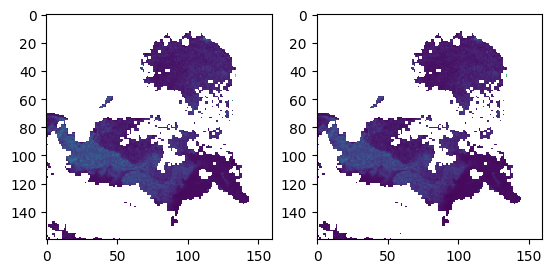

Max Pixels: 12349
Number of 20 day blocks: 127
Shape of single chl block: (20, 160, 160)
Time array: DatetimeIndex(['2016-05-01', '2016-05-02', '2016-05-03', '2016-05-04',
               '2016-05-05', '2016-05-06', '2016-05-07', '2016-05-08',
               '2016-05-09', '2016-05-10',
               ...
               '2023-04-06', '2023-04-07', '2023-04-08', '2023-04-09',
               '2023-04-10', '2023-04-11', '2023-04-12', '2023-04-13',
               '2023-04-14', '2023-04-15'],
              dtype='datetime64[ns]', length=2541, freq='D')
Numer of 20 day times: 127
Length of total Time array: 2541
Train data indices: [ 68  69  12  42  31  27  24  93 110  91  15  76  22  47  64 105  30  83
  66   9  33  65  25  73  28  56 124  53   5  67  97  39  49  35  16  70
  34  84   7  43 121 118 107   8  13  89   3  17  38  72 112   6 117 109
 101  54  50  85  46 116  61 123  79 100  41  58  90  48  88 108  57  75
  32 119  59  63 122  37  29 113   1  52  21   2  23 103  99  87 115  74
  8

In [ ]:
prepare_olci_data(input_dir_RIGA, output_dir, 'RIGA')

CHL_data_7.npy
CHL_data_8.npy
CHL_data_9.npy
CHL_data_10.npy
CHL_data_11.npy
CHL_data_12.npy
CHL_data_13.npy
CHL_data_14.npy
(2541, 160, 160)


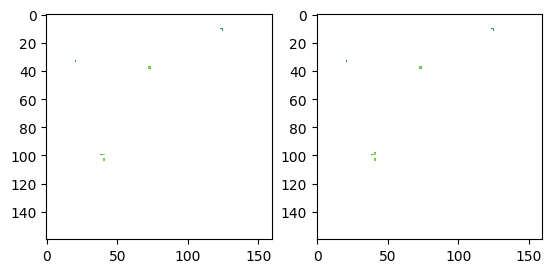

Max Pixels: 16139
Number of 20 day blocks: 127
Shape of single chl block: (20, 160, 160)
Time array: DatetimeIndex(['2016-05-01', '2016-05-02', '2016-05-03', '2016-05-04',
               '2016-05-05', '2016-05-06', '2016-05-07', '2016-05-08',
               '2016-05-09', '2016-05-10',
               ...
               '2023-04-06', '2023-04-07', '2023-04-08', '2023-04-09',
               '2023-04-10', '2023-04-11', '2023-04-12', '2023-04-13',
               '2023-04-14', '2023-04-15'],
              dtype='datetime64[ns]', length=2541, freq='D')
Numer of 20 day times: 127
Length of total Time array: 2541
Train data indices: [100 109  44  66  46  93  70  72 101 118  55 122 113  57  32  65  92 108
 123  36  83  69  59 119  50  14  79  35  88  67 110  26   8 115  42   0
  87  10  95  28  63  43  68   5  40 112  96  37  17  25 114  48  75  74
  33  77 111  11  81   7  58  76   3  62 121  21  78  23 116  27  49  13
 107  19  51  53  71  99   9  73  61  31  22  54  80  30  85  24  56 117
 12

In [ ]:
prepare_olci_data(input_dir_KTT, output_dir, 'KTT')

CHL_data_7.npy
CHL_data_8.npy
CHL_data_9.npy
CHL_data_10.npy
CHL_data_11.npy
CHL_data_12.npy
CHL_data_13.npy
CHL_data_14.npy
(2541, 160, 160)


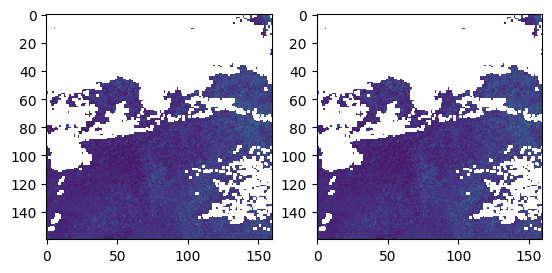

Max Pixels: 25600
Number of 20 day blocks: 127
Shape of single chl block: (20, 160, 160)
Time array: DatetimeIndex(['2016-05-01', '2016-05-02', '2016-05-03', '2016-05-04',
               '2016-05-05', '2016-05-06', '2016-05-07', '2016-05-08',
               '2016-05-09', '2016-05-10',
               ...
               '2023-04-06', '2023-04-07', '2023-04-08', '2023-04-09',
               '2023-04-10', '2023-04-11', '2023-04-12', '2023-04-13',
               '2023-04-14', '2023-04-15'],
              dtype='datetime64[ns]', length=2541, freq='D')
Numer of 20 day times: 127
Length of total Time array: 2541
Train data indices: [ 40  25  60  44  95  14  66  82  62  72  37  88  93  39   3  21  63  68
  22  67   7  10  31   8  50 117  55  84 104  35  76  87 119  81  91  61
 114  51  69  79  54  32  86   6   5 123  33 116  58  41 107  26  75  57
 108  15 124  83 120  59  94  42  28 102 112  11  16   2  24  34 111  13
  80  85   1  23 101  36 115  45  73 110  46 126  52   9 121  48  56  12
  9

In [ ]:
prepare_olci_data(input_dir_GTL, output_dir, 'GTL')

82.02215576171875
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]


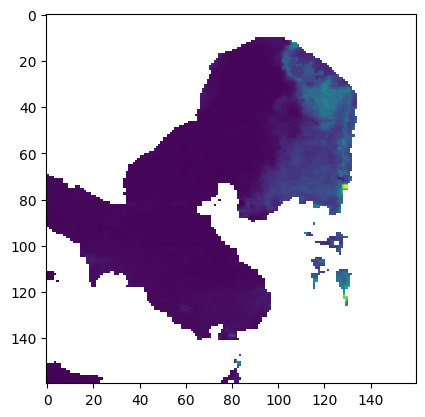

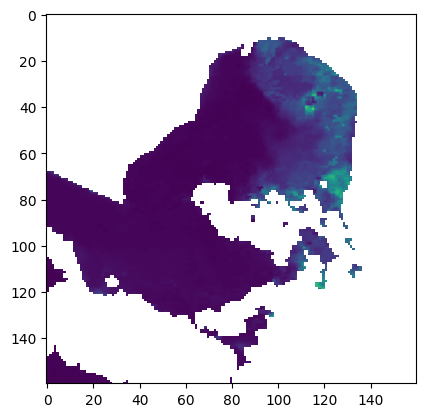

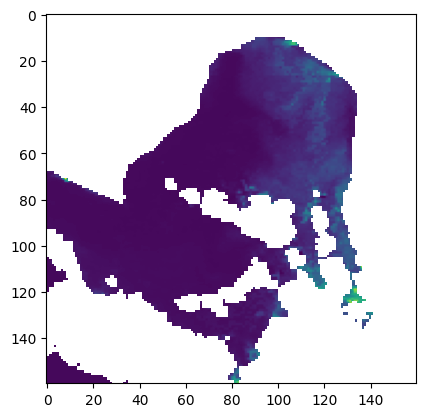

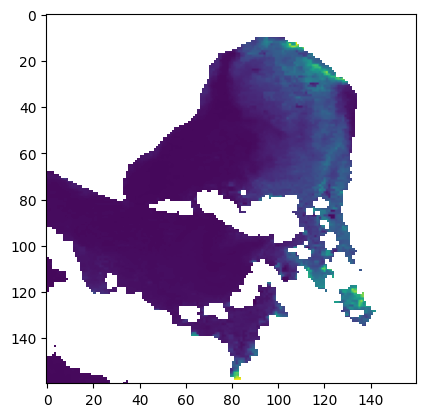

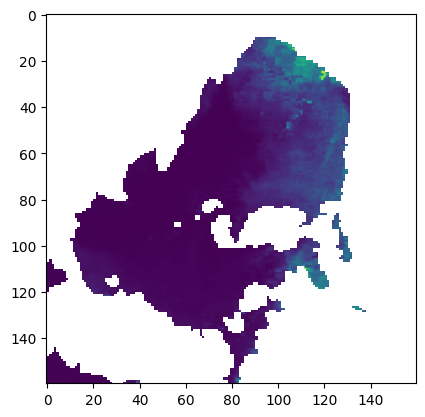

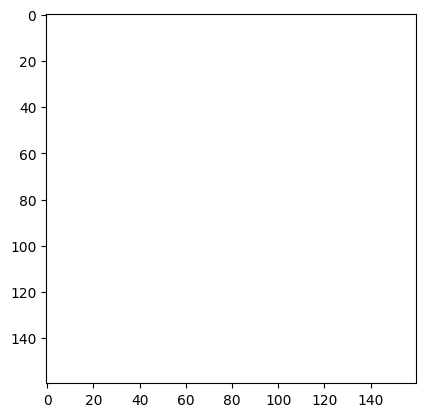

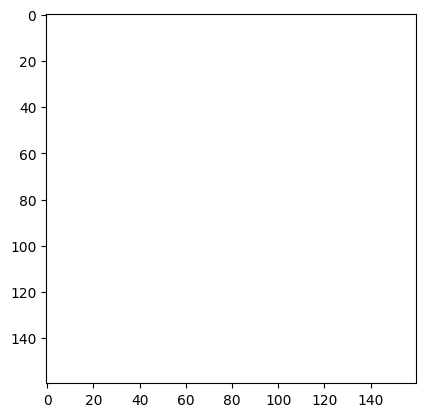

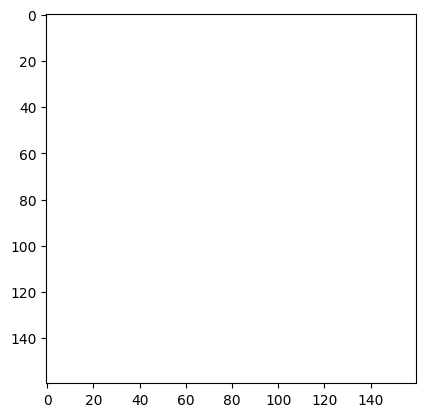

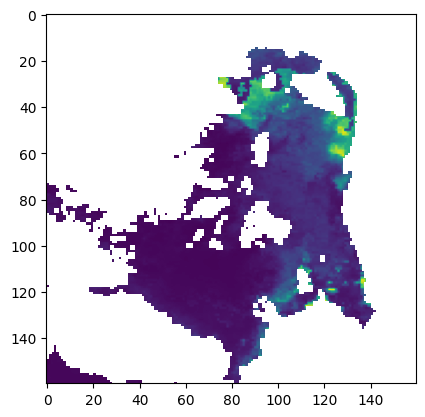

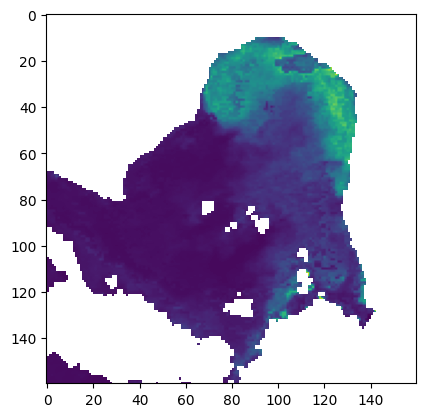

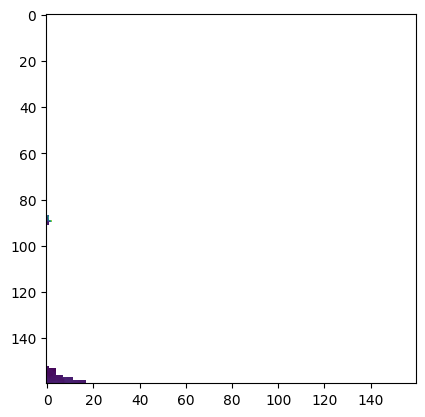

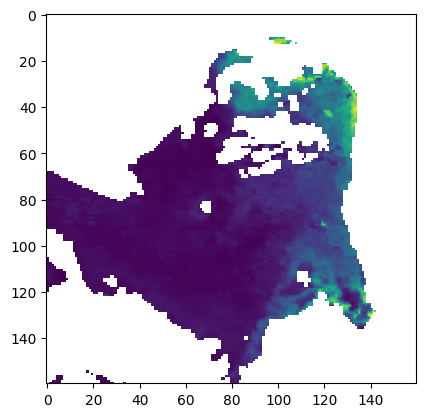

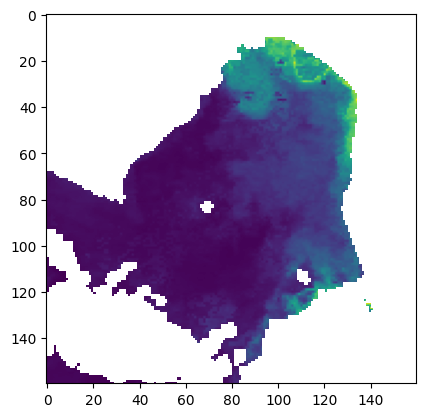

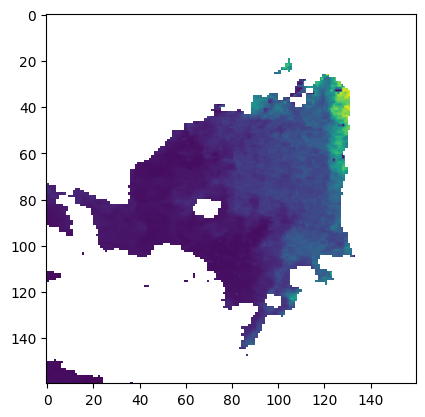

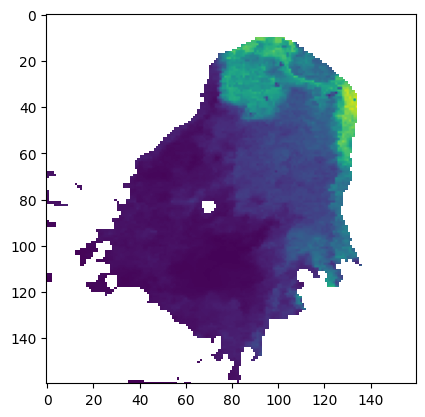

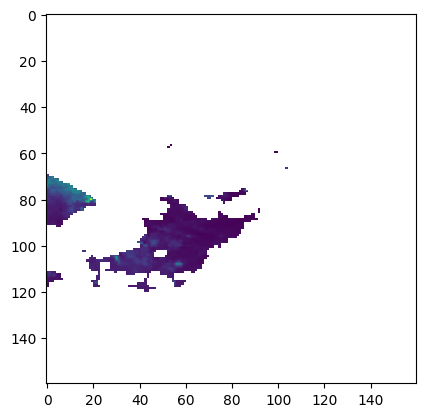

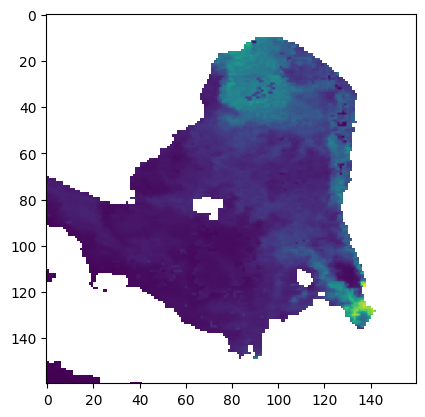

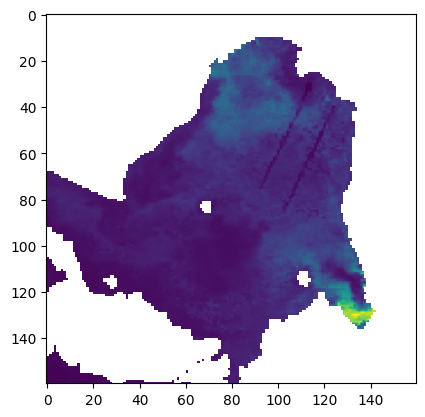

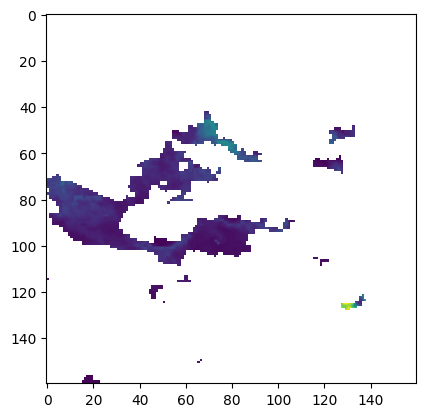

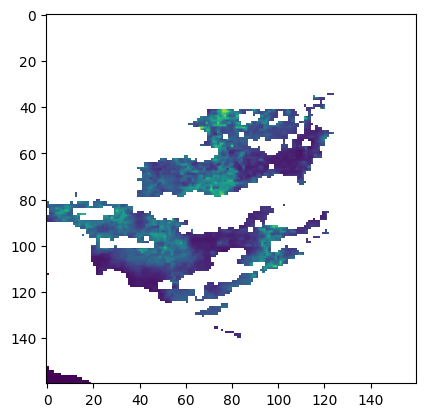

In [ ]:
#%%
data_dir = f'{output_dir}/TrainData_NC_RIGA/file_multi_50-100_120.nc' #olci_1
data = xr.open_dataset(f"{data_dir}")


data_values = data['CHL'].values #.to_array()
mask_values = data['mask'].values

print(np.nanmax(data_values))

print(mask_values)

fig = plt.figure()
for i in range(data_values.shape[0]):
    plt.imshow(data_values[i,:,:])
    plt.show()

### Concat both Datasets and get coxbox value

In [ ]:
mixed = np.append(chl_array_multi, chl_array_olci, axis=0)
print(mixed.shape)

(11426, 160, 160)


In [ ]:
from scipy import stats
coxbox_multi, lamb_multi = stats.boxcox(chl_array_multi[~np.isnan(chl_array_multi)])
print(lamb_multi)

coxbox_olci, lamb_olci = stats.boxcox(chl_array_olci[~np.isnan(chl_array_olci)])
print(lamb_olci)

-0.2816107171659248
0.26697942146031406


In [ ]:
print(np.max(coxbox_multi), np.min(coxbox_multi))
print(np.max(coxbox_olci), np.min(coxbox_olci))

2.7464589875132868 -2.7884672658092775
11.056129599855101 -1.078150394134911


In [ ]:
# create the tiff files for the pCONV3D model
# 1 is land, 0 is water
landmask_tiff = np.tile(landmask,(chl_array.shape[0],1,1))
print(landmask_tiff.shape)

## Get the min/max values of both datasets

In [ ]:
print(f"Multi max = {np.nanmax(chl_array_multi)}")
print(f"Multi min = {np.nanmin(chl_array_multi)}")
print(f"Olci max = {np.nanmax(chl_array_olci)}")
print(f"Olci min = {np.nanmin(chl_array_olci)}")

Multi max = 194.84649658203125
Multi min = 0.12770438194274902
Olci max = 171.9263916015625
Olci min = 0.2804170846939087
